In [1]:
%reload_ext autoreload
%autoreload
#%aimport

import numpy as np

from Electromagnetics.RecGridND import *


x0, x1, dx = None, None, None
n_dim = 1
BC = 'IC'
make_refinements = False

from enum import Enum
class EqType(Enum):
    has_coeff = 1
    has_coeff_par = 2
    has_rhs = 3
    has_der_0 = 4
    const_coeff = 5
    
eq_type = EqType.has_coeff_par

if eq_type == EqType.has_der_0:
    assert n_dim==2 and BC=='IC'
    
solve_twice = False
extrapolate = False


if n_dim==1:
    x0 = np.array([1.0])
    x1 = np.array([10.1])
    dx = np.array([0.05])
elif n_dim==2:
    x0 = np.array([0.2, 0.1])
    x1 = np.array([0.25, 1.5])
    dx = np.array([0.03, 0.1])
elif n_dim==3:
    x0 = np.array([0.0, 0.0, 0.0])
    x1 = np.array([1.0, 1.0, 1.0])
    dx = np.array([0.35, 0.25, 0.20])

    
rg = RGND(x0, x1, dx)

""" ##BC singularity test 
rg.NodesGetConnectedCells()
rg.SetupBoundaryCellConnections()
cells_ref = {0:[0]}
#cells_ref = {0:[11,12,13,14,15,16,17,18,28,38,48,58,68,78,88,87,86,85,84,83,82,81,71,61,51,41,31,21]}
#cells_ref = {0:[0,1,2,3,4,5,6,7,8,9,10,20,30,40,50,60,70,80,90]}
#cells_ref = {0:[i for i in range(100) if i not in list(range(10))+list(range(10,100,10))+list(range(91,100))+list(range(9,99,10))]}
cells_ref = rg.MarkAdditionalCellsForRefinement_PeriodicBoundary(cells_ref)
rg.RefineCells(cells_ref)
"""

if make_refinements:
    n_tot_0 = len(rg.cellsHier[0])
    n_ref = int(n_tot_0/5)

    cells_ref = {}

    import random
    cells_ref[0] = list(set([random.randint(0, n_tot_0-1) for i in range(n_ref)]))
    print('cells_ref: ', cells_ref)

    rg.NodesGetConnectedCells()
    rg.SetupBoundaryCellConnections()
    #cells_ref = rg.MarkAdditionalCellsForRefinement(cells_ref)
    cells_ref = rg.MarkAdditionalCellsForRefinement_PeriodicBoundary(cells_ref)
    print('cells_ref: ', cells_ref)

    rg.RefineCells(cells_ref)
    print('Refinement verification:', rg.VerifyCellsContinuity())

    n_tot_1 = len(rg.cellsHier[1])
    cells_ref = {0:[]}
    cells_ref[1] = list(set([random.randint(0, n_tot_1-1) for i in range(n_ref)]))
    print('cells_ref: ', cells_ref)

    rg.NodesGetConnectedCells()
    rg.SetupBoundaryCellConnections()
    #cells_ref = rg.MarkAdditionalCellsForRefinement(cells_ref)
    cells_ref = rg.MarkAdditionalCellsForRefinement_PeriodicBoundary(cells_ref)
    print('cells_ref: ', cells_ref)

    rg.RefineCells(cells_ref)
    print('Refinement verification:', rg.VerifyCellsContinuity())

    cells_ref = {}
    n_tot_0 = len(rg.cellsHier[0])
    n_tot_1 = len(rg.cellsHier[1])
    n_tot_2 = len(rg.cellsHier[2])
    cells_ref[0] = list(set([random.randint(0, n_tot_0-1) for i in range(n_ref)]))
    cells_ref[1] = list(set([random.randint(0, n_tot_1-1) for i in range(n_ref)]))
    cells_ref[2] = list(set([random.randint(0, n_tot_2-1) for i in range(n_ref)]))
    print('cells_ref: ', cells_ref)

    rg.NodesGetConnectedCells()
    rg.SetupBoundaryCellConnections()
    #cells_ref = rg.MarkAdditionalCellsForRefinement(cells_ref)
    cells_ref = rg.MarkAdditionalCellsForRefinement_PeriodicBoundary(cells_ref)
    print('cells_ref: ', cells_ref)

    rg.RefineCells(cells_ref)

rg.NodesGetConnectedCells()
rg.SetupBoundaryCellConnections()
assert rg.VerifyInternalAndBorderCellsContinuity()

rg.verbose=0


-- [182] 182


In [2]:
from sympy import symbols, Function, Derivative, latex, sin, cos, lambdify
from IPython.display import display, Math, Latex

x, y, z = symbols('x, y, z')


f_exa = None

if n_dim==1:
    x = symbols('x')
    f = Function('f')(x)
    alpha = Function('\\alpha')(x)
    beta = Function('\\beta')(x)
    
    eq_0 = None
    if eq_type==EqType.has_coeff_par:
        eq_0 = Derivative(f, x, 2) + (16.0+alpha)*f + Derivative(beta, x)*cos(4*x) 
        f_exa = cos(4*x)
    elif eq_type==EqType.has_coeff:
        eq_0 = Derivative(f, x, 2) + (16.0+sin(x))*f - sin(x)*cos(4*x) 
        f_exa = cos(4*x)
    elif eq_type==EqType.has_rhs:
        eq_0 = Derivative(f, x, 2) + 16.0*f - 16.0*x
        f_exa = cos(4*x) + x
    else:
        eq_0 = Derivative(f, x, 2) + 16.0*f 
        f_exa = cos(4*x)

        
    print('differential equation:')
    display(Math(latex(eq_0)))
    display(Math(latex(f_exa)))

    if eq_type==EqType.has_coeff_par:
        rg.AttachDiffEquations(eqs_list=[eq_0], vars_list=[f], pars_list=[alpha, beta], indepVars_list=[x])
        rg.SetParsValues([sin(x), cos(x)])
    else:
        rg.AttachDiffEquations(eqs_list=[eq_0], vars_list=[f], pars_list=[], indepVars_list=[x])

    eq_parts = rg.DisintegrateEquations()
    print(eq_parts)

        
    ##-- boundary coditions
    rg.ResetBoundaryConditions()
    if BC == 'BC':
        f_x0 = f_exa.subs(x, x0[0])
        f_x1 = f_exa.subs(x, x1[0])
        print('f_x0:', f_x0, 'f_x1:', f_x1)
        rg.AddBoundaryCondition({'expr':f-f_x0, 'dir':0, 'face':'n'})
        rg.AddBoundaryCondition({'expr':f-f_x1, 'dir':0, 'face':'p'})
    else:
        assert BC=='IC'
        f_x0 = f_exa.subs(x, x0[0])
        df_x0 = Derivative(f_exa, x).doit().subs(x, x0[0])
        print('f_x0:', f_x0, 'df_x0:', df_x0)
        rg.AddBoundaryCondition({'expr':f-f_x0, 'dir':0, 'face':'n'})
        rg.AddBoundaryCondition({'expr':Derivative(f,x,1)-df_x0, 'dir':0, 'face':'n'})

    f_cc = []
    f_cc.append({'der':0, 'dir':0, 'face':'n'})
    f_cc.append({'der':1, 'dir':0, 'face':'n'})
    rg.DefineContinuityCondsAcrossCellBorders({f:f_cc})


    poly_order = [[5]]
    poly_order_max = [[3]]
    der_order_max = [[2]]
    
elif n_dim==2:
    x, y, z = symbols('x, y, z')
    f = Function('f')(x,y)

    if eq_type==EqType.has_coeff:
        eq_0 = Derivative(f, x, 2) + Derivative(f, y, 2) + (2+sin(x+y))*f - sin(x+y)*cos(x)*cos(y)
        f_exa = cos(x)*cos(y)
    elif eq_type==EqType.has_der_0:
        eq_0 = Derivative(f, x, 2) - cos(y)
        f_exa = x**2/2*cos(y) + x*sin(y) + (1-y)
    else:
        eq_0 = Derivative(f, x, 2) + Derivative(f, y, 2) + 2*f
        f_exa = cos(x)*cos(y)

    print('differential equation:')
    display(Math(latex(eq_0)))

    #rg.AttachDiffEquations(eqs_list=[eq_0, eq_1], vars_list=[f, g], pars_list=[gamma], indepVars_list=[x, y])
    rg.AttachDiffEquations(eqs_list=[eq_0], vars_list=[f], pars_list=[], indepVars_list=[x, y])

    eq_parts = rg.DisintegrateEquations()
    print(eq_parts)

    ##-- boundary coditions
    rg.ResetBoundaryConditions()
    if eq_type==EqType.has_der_0:
        if BC=='IC':        
            f_x0 = f_exa.subs(x, x0[0])
            df_x0 = Derivative(f_exa, x).doit().subs(x, x0[0])
            rg.AddBoundaryCondition({'expr':f-f_x0, 'dir':0, 'face':'n'})
            rg.AddBoundaryCondition({'expr':Derivative(f,x,1)-df_x0, 'dir':0, 'face':'n'})
        else:
            raise NotImplementedError()
    else:
        if BC == 'BC':
            f_x0 = f_exa.subs(x, x0[0])
            f_x1 = f_exa.subs(x, x1[0])
            f_y0 = f_exa.subs(y, x0[1])
            f_y1 = f_exa.subs(y, x1[1])
            rg.AddBoundaryCondition({'expr':f-f_x0, 'dir':0, 'face':'n'})
            rg.AddBoundaryCondition({'expr':f-f_x1, 'dir':0, 'face':'p'})
            rg.AddBoundaryCondition({'expr':f-f_y0, 'dir':1, 'face':'n'})
            rg.AddBoundaryCondition({'expr':f-f_y1, 'dir':1, 'face':'p'})
        elif BC=='IC':        
            f_x0 = f_exa.subs(x, x0[0])
            df_x0 = Derivative(f_exa, x).doit().subs(x, x0[0])
            f_y0 = f_exa.subs(y, x0[1])
            df_y0 = Derivative(f_exa, y).doit().subs(y, x0[1])
            rg.AddBoundaryCondition({'expr':f-f_x0, 'dir':0, 'face':'n'})
            rg.AddBoundaryCondition({'expr':Derivative(f,x,1)-df_x0, 'dir':0, 'face':'n'})
            rg.AddBoundaryCondition({'expr':f-f_y0, 'dir':1, 'face':'n'})
            rg.AddBoundaryCondition({'expr':Derivative(f,y,1)-df_y0, 'dir':1, 'face':'n'})
        elif BC=='BCIC':
            f_x0 = f_exa.subs(x, x0[0])
            f_x1 = f_exa.subs(x, x1[0])
            f_y0 = f_exa.subs(y, x0[1])
            df_y0 = Derivative(f_exa, y).doit().subs(y, x0[1])
            rg.AddBoundaryCondition({'expr':f-f_x0, 'dir':0, 'face':'n'})
            rg.AddBoundaryCondition({'expr':f-f_x1, 'dir':0, 'face':'p'})
            rg.AddBoundaryCondition({'expr':f-f_y0, 'dir':1, 'face':'n'})
            rg.AddBoundaryCondition({'expr':Derivative(f,y,1)-df_y0, 'dir':1, 'face':'n'})
        else:
            raise NotImplementedError()
        

    f_cc = []
    if eq_type==EqType.has_der_0:
        f_cc.append({'der':0, 'dir':0, 'face':'n'})
        f_cc.append({'der':1, 'dir':0, 'face':'n'})
    else:
        f_cc.append({'der':0, 'dir':0, 'face':'n'})
        f_cc.append({'der':0, 'dir':1, 'face':'n'})
        f_cc.append({'der':1, 'dir':0, 'face':'n'})
        f_cc.append({'der':1, 'dir':1, 'face':'n'})
    rg.DefineContinuityCondsAcrossCellBorders({f:f_cc})

    if eq_type==EqType.has_der_0:
        poly_order = [[5, 7]]
        poly_order_max = [[3, 7]]
        der_order_max = [[2, 0]]
    else:
        poly_order = [[9, 9]]
        poly_order_max = [[7, 7]]
        der_order_max = [[2, 2]]
        
elif n_dim==3:
    x, y, z = symbols('x, y, z')
    f = Function('f')(x,y,z)

    if eq_type==EqType.has_coeff:
        eq_0 = Derivative(f, x, 2) + Derivative(f, y, 2) + Derivative(f, z, 2) + (3+sin(x+y+z))*f - sin(x+y+z)*cos(x)*cos(y)*cos(z)
    else:
        eq_0 = Derivative(f, x, 2) + Derivative(f, y, 2) + Derivative(f, z, 2) + 3*f
    print('differential equation:')
    display(Math(latex(eq_0)))

    #rg.AttachDiffEquations(eqs_list=[eq_0, eq_1], vars_list=[f, g], pars_list=[gamma], indepVars_list=[x, y])
    rg.AttachDiffEquations(eqs_list=[eq_0], vars_list=[f], pars_list=[], indepVars_list=[x, y, z])

    eq_parts = rg.DisintegrateEquations()
    print(eq_parts)

    ##-- boundary coditions
    rg.ResetBoundaryConditions()
    if BC == 'BC':
        rg.AddBoundaryCondition({'expr':f-cos(y)*cos(z), 'dir':0, 'face':'n'})
        rg.AddBoundaryCondition({'expr':f-cos(x1[0])*cos(y)*cos(z), 'dir':0, 'face':'p'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(z), 'dir':1, 'face':'n'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(x1[1])*cos(z), 'dir':1, 'face':'p'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(y), 'dir':2, 'face':'n'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(y)*cos(x1[2]), 'dir':2, 'face':'p'})
    elif BC=='IC':
        rg.AddBoundaryCondition({'expr':f-cos(y)*cos(z), 'dir':0, 'face':'n'})
        rg.AddBoundaryCondition({'expr':Derivative(f,x,1), 'dir':0, 'face':'n'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(z), 'dir':1, 'face':'n'})
        rg.AddBoundaryCondition({'expr':Derivative(f,y,1), 'dir':1, 'face':'n'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(y), 'dir':2, 'face':'n'})
        rg.AddBoundaryCondition({'expr':Derivative(f,z,1), 'dir':2, 'face':'n'})
    elif BC=='BCIC':
        rg.AddBoundaryCondition({'expr':f-cos(y)*cos(z), 'dir':0, 'face':'n'})
        rg.AddBoundaryCondition({'expr':f-cos(x1[0])*cos(y)*cos(z), 'dir':0, 'face':'p'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(z), 'dir':1, 'face':'n'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(x1[1])*cos(z), 'dir':1, 'face':'p'})
        rg.AddBoundaryCondition({'expr':f-cos(x)*cos(y), 'dir':2, 'face':'n'})
        rg.AddBoundaryCondition({'expr':Derivative(f,z,1), 'dir':2, 'face':'n'})
    else:
        raise NotImplementedError()
        

    f_cc = []
    f_cc.append({'der':0, 'dir':0, 'face':'n'})
    f_cc.append({'der':0, 'dir':1, 'face':'n'})
    f_cc.append({'der':0, 'dir':2, 'face':'n'})
    f_cc.append({'der':1, 'dir':0, 'face':'n'})
    f_cc.append({'der':1, 'dir':1, 'face':'n'})
    f_cc.append({'der':1, 'dir':2, 'face':'n'})
    rg.DefineContinuityCondsAcrossCellBorders({f:f_cc})


    poly_order = [[7, 7, 7]]
    poly_order_max = [[5, 5, 5]]
    der_order_max = [[2, 2, 2]]

rg.SetPolynomialBasisFuncs(poly_order)
rg.SetMaxPolyOrderToKeepForEachEq(poly_order_max)
rg.SetMaxDerivativeOrderForEachVar(der_order_max)

x_res = rg.SetupMatrixEQs()
rg.SetPolyBasisCoeffs(x_res)
    
if solve_twice:
    if n_dim==1 and BC=='IC':
        bcinds_cc = [0, 1]
        cc_equiv = [{'v_ind':0, 'dir':0, 'der':0, 'face':'n'},
                    {'v_ind':0, 'dir':0, 'der':1, 'face':'n'}]
        rg.AdvanceCornerInVarDir(x)
        x_res = rg.ResetRHSUseCCasIC_Leapfrog(bcinds_cc, cc_equiv, params_extern=None)
        rg.SetPolyBasisCoeffs(x_res)
    if n_dim==2 and BC=='IC':
        bcinds_cc = [0, 1]
        cc_equiv = [{'v_ind':0, 'dir':0, 'der':0, 'face':'n'},
                    {'v_ind':0, 'dir':0, 'der':1, 'face':'n'}]
        rg.AdvanceCornerInVarDir(x)
        x_res = rg.ResetRHSUseCCasIC_Leapfrog(bcinds_cc, cc_equiv, params_extern=None)
        rg.SetPolyBasisCoeffs(x_res)
elif extrapolate:
    if n_dim==1 and BC=='IC':
        der_order = [0]
        rg.GetCellBoundPolyCoeffOnFaceTemp_scaled_masked(poly_order=poly_order[0], vp_der_ord_max=der_order_max[0])
        rg.RegisterICFieldsAtTheGivenSurface(v_ind=0, n_dir=0, face='p', der_order=der_order)
        rg.RegisterFieldsAtTheGivenSurface(v_ind=0, n_dir=0, face='p', der_order=der_order)
        for i in range(poly_order[0][0]):
            bcinds_cc = [0, 1]
            cc_equiv = [{'v_ind':0, 'dir':0, 'der':0, 'face':'n'},
                        {'v_ind':0, 'dir':0, 'der':1, 'face':'n'}]
            rg.AdvanceCornerInVarDir(x)
            x_res = rg.ResetRHSUseCCasIC_Leapfrog(bcinds_cc, cc_equiv, n_dir_lf=0)
            rg.SetPolyBasisCoeffs(x_res)
            rg.RegisterFieldsAtTheGivenSurface(v_ind=0, n_dir=0, face='p', der_order=der_order)
            
        rg.AdvanceCornerInVarDir(x)
        rg.ExtrapolateRegisteredFieldsAndSetPolyBasisCoeffs(poly_order=poly_order[0], n_dir=0, \
                                                            face='p', der_order=der_order)
    elif n_dim==2 and BC=='IC':
        der_order = [0,0]
        rg.GetCellBoundPolyCoeffOnFaceTemp_scaled_masked(poly_order=poly_order[0], vp_der_ord_max=der_order_max[0])
        rg.RegisterICFieldsAtTheGivenSurface(v_ind=0, n_dir=0, face='p', der_order=der_order)
        rg.RegisterFieldsAtTheGivenSurface(v_ind=0, n_dir=0, face='p', der_order=der_order)
        for i in range(poly_order[0][0]):
            bcinds_cc = [0, 1]
            cc_equiv = [{'v_ind':0, 'dir':0, 'der':0, 'face':'n'},
                        {'v_ind':0, 'dir':0, 'der':1, 'face':'n'}]
            rg.AdvanceCornerInVarDir(x)
            x_res = rg.ResetRHSUseCCasIC_Leapfrog(bcinds_cc, cc_equiv, n_dir_lf=0)
            rg.SetPolyBasisCoeffs(x_res)
            rg.RegisterFieldsAtTheGivenSurface(v_ind=0, n_dir=0, face='p', der_order=der_order)
            
        rg.AdvanceCornerInVarDir(x)
        rg.ExtrapolateRegisteredFieldsAndSetPolyBasisCoeffs(poly_order=poly_order[0], n_dir=0, \
                                                            face='p', der_order=der_order)
        
    
print(x_res)
print('x:', x_res, 'min:', min(np.abs(x_res)), 'max:', max(np.abs(x_res)), sep='\n')


differential equation:


<IPython.core.display.Math object>

<IPython.core.display.Math object>

[[[[[\alpha(x) + 16.0, 0, []], [1, 2, [x, x]]]]], [-cos(4*x)*Derivative(\beta(x), x)]]
f_x0: -0.653643620863612 df_x0: 3.02720998123171


<IPython.core.display.Math object>

<IPython.core.display.Math object>

self.mask_allp:
[1 1 1 1 1 1 0 0]
self.mask_xp:
[0 0 1 1 1 1 0 0]
self.mask_x_F:
[0, 0, 1, 1, 1, 1]
self.inds_0_allp:
[ 0  1  2  3  4  5 -1 -1]
self.inds_0_all_F:
[[0, (0,)], [1, (1,)], [2, (2,)], [3, (3,)], [4, (4,)], [5, (5,)]]
self.inds_keep:
[1 1 1 1 1 1]
self.inds_keep__x_weight:
[[[0, 2, 1.0], [1, 3, 1.0], [2, 4, 1.0], [3, 5, 1.0]]]
------------------------------


<IPython.core.display.Math object>

<IPython.core.display.Math object>

[ -6.53643621e-01+0.j   1.51360499e-01+0.j   1.30728724e-02+0.j ...,
   7.97244211e-04+0.j  -5.34359968e-05+0.j  -1.59448334e-06+0.j]
x:
[ -6.53643621e-01+0.j   1.51360499e-01+0.j   1.30728724e-02+0.j ...,
   7.97244211e-04+0.j  -5.34359968e-05+0.j  -1.59448334e-06+0.j]
min:
2.3337565988e-08
max:
0.999933560251


In [5]:
n_pts_dim = [200]*n_dim
gslice=None
if n_dim==3:
    gslice = [{'dir':0, 'val':0.5}]
mesh, var_vals = rg.GetVarValuesOnMesh(0, n_pts_dim, gslice)


/home/nima/ipython workspace/Electromagnetics/RecGridND.py:5185: ComplexWarning: Casting complex values to real discards the imaginary part
  var_vals[i] = self.GetVariableValueAtPointsInsideCell(var_ind, lev, c_ind, [pt_i], printit=printit)[0]


Populating the interactive namespace from numpy and matplotlib
(200,) (200,)


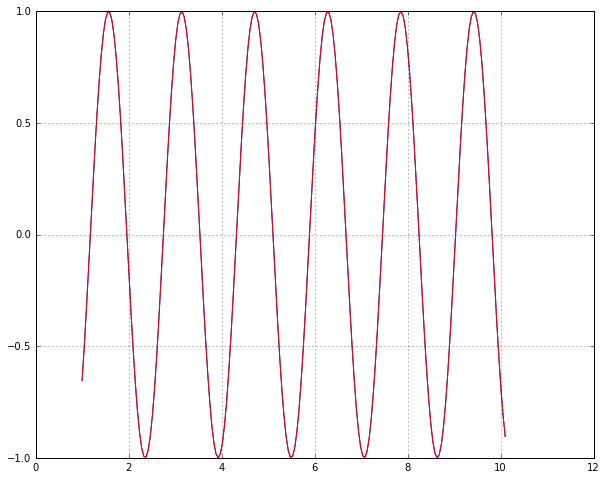

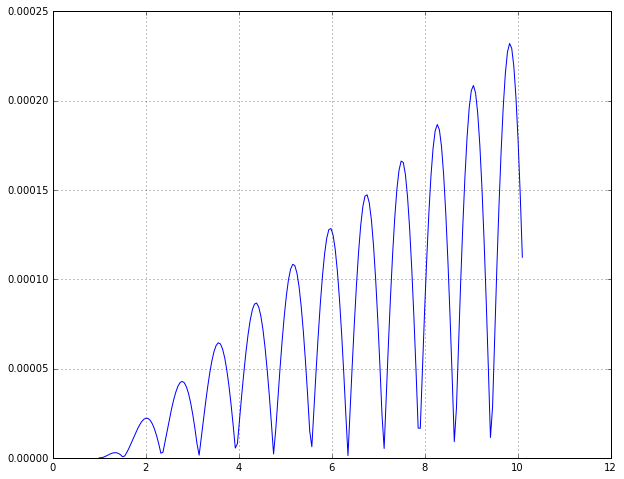

In [6]:
%pylab inline

figsize(10,8)
if n_dim==1:
    X, Y = mesh[0]+rg.x0[0], var_vals
    print(X.shape, Y.shape)
    plot(X, Y)
    
    Y_0 = lambdify(x, f_exa, 'numpy')(X)
    plot(X, Y_0, 'r')
    grid()
    show()
    
    Y_err = np.abs(Y_0 - Y)
    plot(X, Y_err)
    grid()
    show()
        
elif n_dim==2:
    X, Y = mesh[0]+rg.x0[0], mesh[1]+rg.x0[1]
    Z = var_vals
    print('max:', np.max(np.abs(Z)), 'min:', np.min(np.abs(Z)))
    #im = imshow(Z, interpolation='bilinear', cmap=cm.rainbow)#, origin='lower', extent=[-3,3,-3,3], vmax=abs(Z).max(), vmin=-abs(Z).max())
    im = pcolor(X, Y, Z)
    CBI = plt.colorbar(im, orientation='vertical', shrink=1.0)
    show()
    
    Z_anal = lambdify((x,y), f_exa, 'numpy')(X, Y)
    Z_err = np.abs(Z-Z_anal)
    #im = imshow(Z_err, interpolation='bilinear', cmap=cm.rainbow)
    im = pcolor(X, Y, Z_err)
    CBI = plt.colorbar(im, orientation='vertical', shrink=1.0)
    show()
elif n_dim==3:
    Z = var_vals
    print('max:', np.max(np.abs(Z)), 'min:', np.min(np.abs(Z)))
    im = imshow(Z, interpolation='bilinear', cmap=cm.rainbow)#, origin='lower', extent=[-3,3,-3,3], vmax=abs(Z).max(), vmin=-abs(Z).max())
    CBI = plt.colorbar(im, orientation='vertical', shrink=1.0)
    show()
    
    X, Y = mesh[0], mesh[1]
    Z_anal = np.cos(X)*np.cos(Y)*cos(0.5)
    Z_err = np.abs(Z-Z_anal)
    im = imshow(Z_err, interpolation='bilinear', cmap=cm.rainbow)
    CBI = plt.colorbar(im, orientation='vertical', shrink=1.0)
    show()
    

### GUI

In [2]:
%reload_ext autoreload
%autoreload

import numpy as np

from Electromagnetics.RecGridND import *
import queue

que = queue.Queue()
print("queue started..")
window = GUIMakerND(W_3D=np.array([2.0, 2.0, 1.0]), que=que)
    
print('window started...')



queue started..
window started...
OnCloseFrame


In [26]:
window.attachRectGrid(rg)

In [5]:
cells_unset= [(2, 103), (2, 41), (2, 146), (2, 223), (3, 52), (2, 129), (2, 202), (2, 22), (2, 67), (2, 249), (2, 187), (3, 69), (3, 24), (2, 166), (1, 227), (3, 45), (2, 63), (3, 62), (2, 151), (1, 133), (2, 269), (1, 199), (3, 2), (2, 6), (2, 115), (2, 233), (3, 64), (2, 53), (2, 171), (3, 85), (3, 40), (2, 32), (2, 259), (3, 61), (1, 221), (2, 197), (2, 17), (3, 12), (3, 74), (3, 1), (2, 234), (3, 18), (3, 80), (2, 219), (3, 56), (2, 198), (1, 131), (2, 18), (2, 95), (1, 205), (1, 68), (2, 1), (2, 183), (3, 28), (2, 239), (3, 90), (3, 17), (1, 33), (2, 209), (2, 147), (2, 265), (2, 85), (2, 23), (2, 141), (1, 179), (3, 6), (2, 79), (1, 253), (2, 229), (3, 68), (1, 226), (3, 89), (3, 44), (2, 60), (1, 121), (2, 210), (3, 33), (2, 43), (2, 193), (2, 266), (1, 198), (2, 131), (2, 69), (2, 142), (2, 251), (3, 78), (2, 7), (1, 66), (2, 189), (2, 230), (1, 119), (3, 84), (3, 60), (2, 44), (2, 153), (2, 194), (2, 271), (3, 49), (1, 193), (2, 241), (3, 77), (3, 0), (2, 8), (2, 190), (2, 55), (2, 34), (2, 261), (2, 81), (2, 154), (2, 19), (2, 137), (2, 225), (3, 72), (3, 16), (2, 56), (1, 32), (2, 101), (3, 37), (2, 39), (2, 221), (2, 262), (3, 54), (2, 82), (2, 65), (2, 138), (2, 185), (2, 226), (3, 26), (1, 225), (2, 273), (3, 88), (1, 120), (2, 61), (2, 102), (3, 32), (2, 40), (2, 149), (2, 222), (1, 109), (2, 267), (3, 53), (2, 87), (1, 197), (2, 205), (2, 143), (3, 4), (2, 113), (2, 186), (1, 255), (2, 231), (3, 66), (3, 25), (2, 169), (2, 274), (3, 42), (2, 62), (2, 257), (2, 45), (2, 150), (2, 195), (3, 48), (2, 206), (3, 14), (2, 71), (3, 76), (2, 114), (2, 191), (3, 65), (3, 82), (3, 41), (2, 217), (2, 258), (3, 58), (1, 107), (1, 222), (2, 155), (2, 93), (1, 195), (2, 243), (2, 181), (3, 30), (2, 237), (2, 57), (3, 81), (3, 36), (2, 145), (2, 218), (2, 201), (2, 21), (1, 206), (1, 177), (2, 0), (2, 77), (3, 70), (3, 29), (2, 165), (3, 46), (2, 58)]
for c_mark in cells_unset:    
    window.MarkRectGridCell(lev=c_mark[0], c_ind=c_mark[1], color=[0.0, 0.0, 1.0])
window.MarkRectGridCell(lev=0, c_ind=0, color=[0.0, 1.0, 0.0])

In [28]:
r0, r1 = np.array([-0.0, -0.0, -0.0]), np.array([0.1, 0.1, 0.3])
que.put(['add elem', 'cube', [r0, r1]])

OnCloseFrame


In [8]:
r0 = np.array([0.0, 0.0, 0.1])
r1 = np.array([0.2, 0.0, 0.1])
r2 = np.array([0.2, 0.2, 0.1])
r3 = np.array([0.0, 0.2, 0.1])

que.put(['add elem', 'quad', [r0, r1, r2, r3]])


In [5]:
que.put(['logtext', 'test'])